## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
#from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Load the dataset

In [2]:
BASE_DIR = 'C:/Users/mrsah/OneDrive/Desktop/Project/Age/Dataset/'

In [3]:
# labels
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

  0%|          | 0/23705 [00:00<?, ?it/s]

## Convertion to dataframe

In [4]:
df = pd.DataFrame()
df['image'] = image_paths 
df['age'] = age_labels
df.head() #default vaule is 5

,image,age
0,C:/Users/mrsah/OneDrive/Desktop/Project/Age/Da...,100
1,C:/Users/mrsah/OneDrive/Desktop/Project/Age/Da...,100
2,C:/Users/mrsah/OneDrive/Desktop/Project/Age/Da...,100
3,C:/Users/mrsah/OneDrive/Desktop/Project/Age/Da...,100
4,C:/Users/mrsah/OneDrive/Desktop/Project/Age/Da...,100


## Exploratory Data Analysis

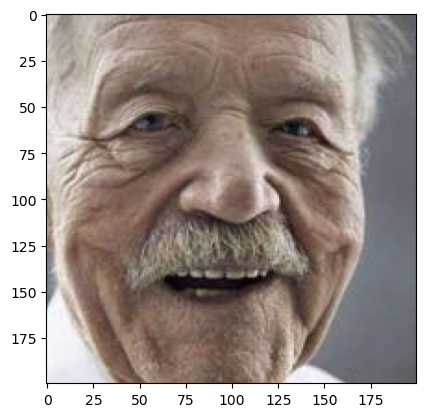

In [5]:
img = Image.open(df['image'][0]) #loading first image
#plt.axis('off') #removes axis with numbers
plt.imshow(img) #;removes extra text

## Age Distribution

<AxesSubplot:xlabel='age', ylabel='Density'>

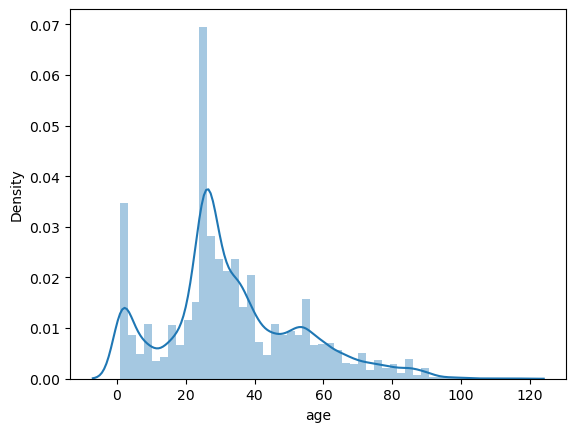

In [6]:
sns.distplot(df['age'])

## To display group of images

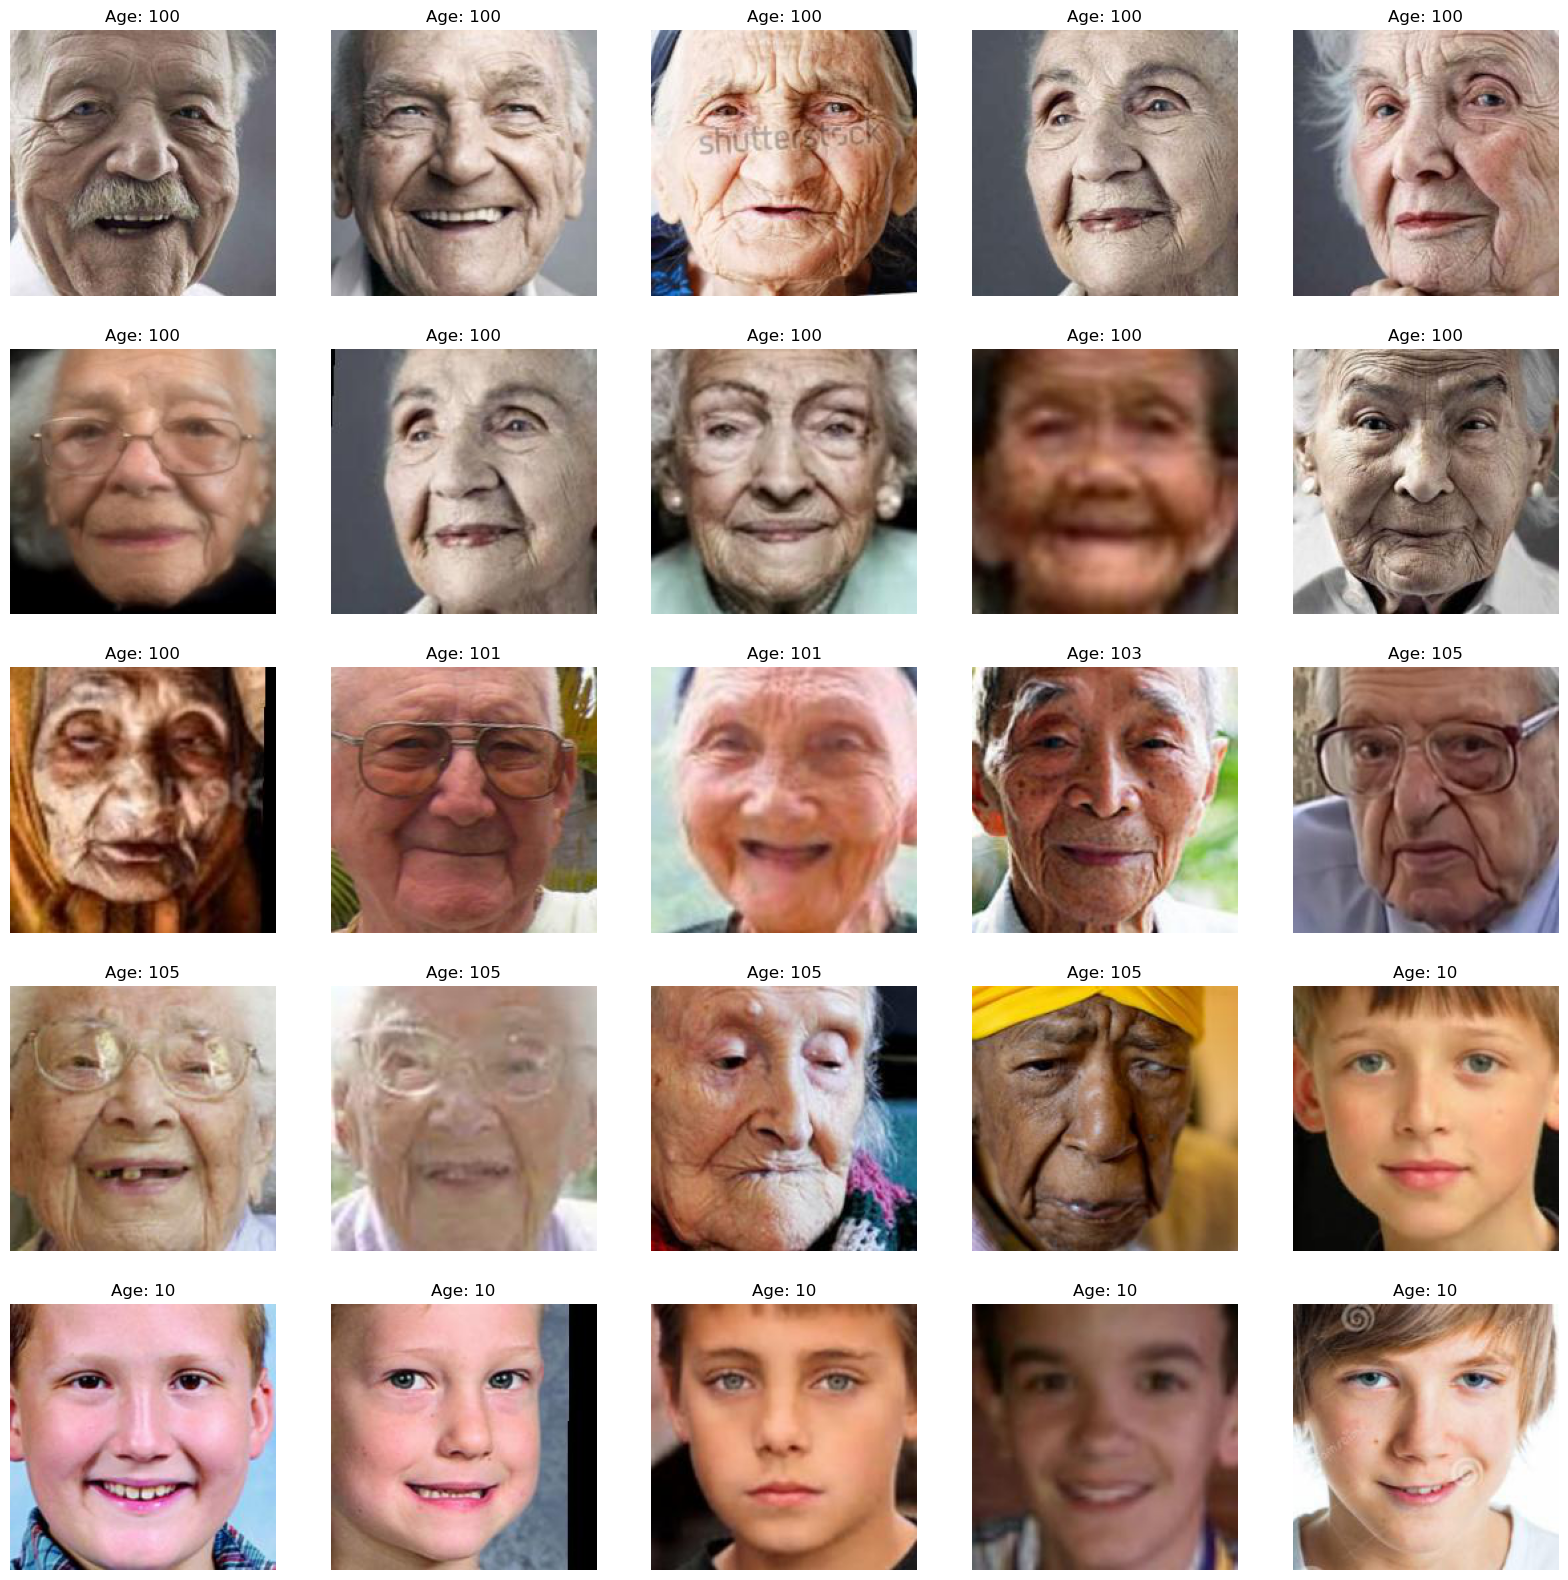

In [7]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

## Image Conversion

In [8]:
def img_conv(images):
    converted = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True) 
        # Loaded in single dimension otherwise in RGB (3 dimensions) will use full memory
        img = img.resize((128,128), Image.ANTIALIAS) 
        # reshapinng image from 200x200 to 128x128 and to avoid distortions in image antialias is used.
        img = np.array(img) # creating array
        converted.append(img) #adding to converted
        
    converted = np.array(converted) #converting convered list to numpy array as CNN only handles numpy array
        # ignore this step if using RGB
    converted = converted.reshape(len(converted),128,128,1)
        #len(converted) is number of samples
        # 128,128 is dimension width and height
        # 3/1 represents RGB = 3 or Grayscale = 1
    return converted

In [9]:
X = img_conv(df['image'])

  0%|          | 0/23705 [00:00<?, ?it/s]

In [10]:
X.shape
print(X.shape)

(23705, 128, 128, 1)


In [11]:
# normalize the images
X = X/255.0
print(X.shape)

(23705, 128, 128, 1)


In [12]:
y_age = np.array(df['age'])

In [16]:
# spliting 80% dataset for train and 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size=0.2, random_state=42)

# spliting training set for validation set ()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_valid shape: {}".format(X_valid.shape))
print("y_valid shape: {}".format(y_valid.shape))

X_train shape: (14223, 128, 128, 1)
y_train shape: (14223,)
X_test shape: (4741, 128, 128, 1)
y_test shape: (4741,)
X_valid shape: (4741, 128, 128, 1)
y_valid shape: (4741,)


In [17]:
input_shape = (128, 128, 1)

## Model

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_siz
                e=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense = Dense(256, activation='relu') (flatten)

dropout = Dropout(0.3) (dense)

output = Dense(1, activation='relu', name='age_out') (dropout)

model = Model(inputs=[inputs], outputs=[output])

model.compile(loss=['mae'], optimizer='adam', metrics=['accuracy'])

In [20]:
model_sum = model.summary() #shows the layers we are having

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

## Training the model

In [21]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
445/445 [==============================] - 199s 446ms/step - loss: 15.5214 - accuracy: 0.0482
Epoch 2/25
445/445 [==============================] - 195s 438ms/step - loss: 11.9117 - accuracy: 0.0392
Epoch 3/25
445/445 [==============================] - 181s 406ms/step - loss: 10.0016 - accuracy: 0.0270
Epoch 4/25
445/445 [==============================] - 185s 416ms/step - loss: 9.0669 - accuracy: 0.0221
Epoch 5/25
445/445 [==============================] - 182s 408ms/step - loss: 8.2512 - accuracy: 0.0188
Epoch 6/25
445/445 [==============================] - 179s 403ms/step - loss: 7.7145 - accuracy: 0.0179
Epoch 7/25
445/445 [==============================] - 179s 401ms/step - loss: 7.4056 - accuracy: 0.0182
Epoch 8/25
445/445 [==============================] - 178s 401ms/step - loss: 6.9818 - accuracy: 0.0203
Epoch 9/25
445/445 [==============================] - 182s 410ms/step - loss: 6.7136 - accuracy: 0.0175
Epoch 10/25
445/445 [==============================] - 178s 4

## Saving files

In [22]:
# Save the training history
history_dict = history.history
history_dict['epoch'] = history.epoch

# Save the history to a JSON file
import json
with open('history.json', 'w') as f:
    json.dump(history_dict, f)
    
# Save the model architecture as a JSON string
model_json = model.to_json()
with open('model.json', 'w') as f:
    f.write(model_json)

    
#model output is saved in file named my_model.h5
model.save('my_model.h5')

# Save the model weights to a file
model.save_weights('model_weights.h5')

## Calculating errors

In [24]:
# Calculate the training error
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)

# Calculate the validation error
val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=0)

# Calculate the testing error
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the errors
print('Training loss:', train_loss)
print('Training accuracy:', train_acc)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_acc)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Training loss: 3.4130144119262695
Training accuracy: 0.04738803207874298
Validation loss: 7.01741361618042
Validation accuracy: 0.045981861650943756
Test loss: 6.954902172088623
Test accuracy: 0.045349083840847015


## Saving error in a file

In [32]:
import csv

# Calculate the loss and accuracy for each set
training_loss, training_accuracy = model.evaluate(X_train, y_train)
validation_loss, validation_accuracy = model.evaluate(X_valid, y_valid)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Open a CSV file for writing
with open('loss_and_accuracy.csv', 'w', newline='') as csvfile:
  # Create a CSV writer
  writer = csv.writer(csvfile)

  # Write the loss and accuracy for each set to the CSV file
  writer.writerow(['Set', 'Loss', 'Accuracy'])
  writer.writerow(['Training', training_loss, training_accuracy])
  writer.writerow(['Validation', validation_loss, validation_accuracy])
  writer.writerow(['Test', test_loss, test_accuracy])


149/149 [==============================] - 17s 115ms/step - loss: 6.9549 - accuracy: 0.0453


## Printing History

In [29]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Print the training error
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

Train loss: [15.521366119384766, 11.911745071411133, 10.001626968383789, 9.066927909851074, 8.251237869262695, 7.714454650878906, 7.405592441558838, 6.98183012008667, 6.713568210601807, 6.444877624511719, 6.128918647766113, 5.870940685272217, 5.711061477661133, 5.39495849609375, 5.24617862701416, 5.021829128265381, 4.8622050285339355, 4.708022594451904, 4.628276348114014, 4.47042989730835, 4.397821426391602, 4.257498741149902, 4.117223262786865, 4.013147830963135, 4.014179229736328]
Train accuracy: [0.048231735825538635, 0.03923222795128822, 0.026998523622751236, 0.022076917812228203, 0.01884271949529648, 0.01785839907824993, 0.018209941685199738, 0.020319201052188873, 0.017506854608654976, 0.017647473141551018, 0.018209941685199738, 0.01708500273525715, 0.021584756672382355, 0.02067074365913868, 0.038740068674087524, 0.042255502194166183, 0.04436476156115532, 0.04457568749785423, 0.045841243118047714, 0.04577093571424484, 0.04577093571424484, 0.04605216905474663, 0.04570062458515167, 

## Saving History with pickle to plot graph

In [35]:
import pickle
# Open a file in write mode
with open('history.pkl', 'wb') as f:
  # Serialize the history object and write it to the file
  pickle.dump(history.history, f)

## Loading model file

In [63]:
loaded_model = tf.keras.models.load_model("my_model.h5")

Original Age: 22
1/1 [==============================] - 0s 145ms/step
Predicted Age: 24


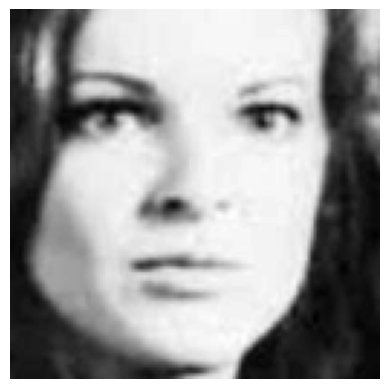

In [64]:
image_index = 3475
print("Original Age:", y_age[image_index])
# predict from model
pred = loaded_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step
Predicted Age: 26


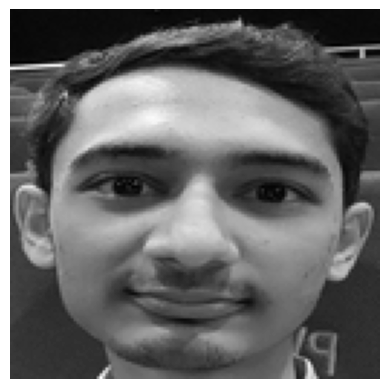

In [65]:
user_image = [r"C:\Users\mrsah\OneDrive\Desktop\me1.jpeg"]
ran_var1 = img_conv(user_image)
#print(ran_var1)
ran_var1 = ran_var1/255.0 #normalizing the input image
#print(ran_var1)



# predict from model
pred = loaded_model.predict(ran_var1.reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(ran_var1.reshape(128, 128), cmap='gray');

Original Age: 10
1/1 [==============================] - 0s 33ms/step
Predicted Age: 14


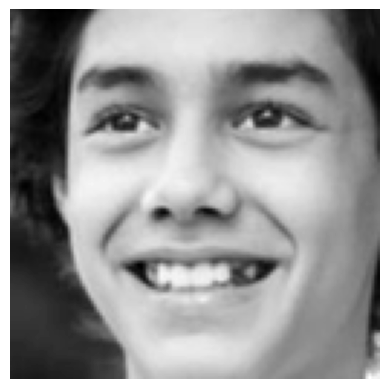

In [66]:
image_index = 100
print("Original Age:", y_age[image_index])
# predict from model
pred = loaded_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Age: 26
1/1 [==============================] - 0s 35ms/step
Predicted Age: 28


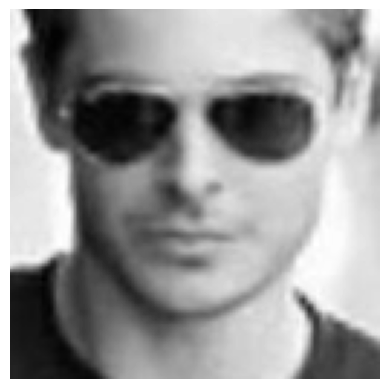

In [67]:
image_index = 5882
print("Original Age:", y_age[image_index])
# predict from model
pred = loaded_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Age: 70
1/1 [==============================] - 0s 32ms/step
Predicted Age: 73


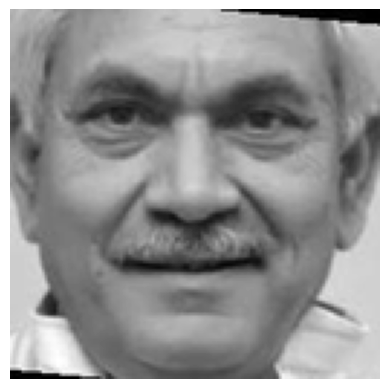

In [68]:
image_index = 21879
print("Original Age:", y_age[image_index])
# predict from model
pred = loaded_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Age: 24
1/1 [==============================] - 0s 39ms/step
Predicted Age: 27


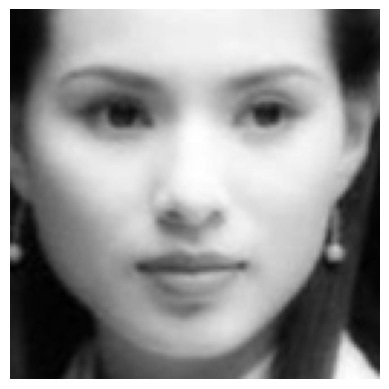

In [69]:
image_index = 4632
print("Original Age:", y_age[image_index])
# predict from model
pred = loaded_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');